In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
import scipy
import pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [28]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.set_style('darkgrid')
plt.rcParams['font.size'] = 20.0
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
import pickle

In [30]:
import graph_learning_utils as gl
import fbpca

# Import multiple species' data

In [5]:
species_ids = [
    9913,
    9606, 
    72004,
    10029, 
    43346
]

In [6]:
bad_species = 10029

In [7]:
species_ids_good = [idx for idx in species_ids if idx != bad_species]

In [8]:
def load_ppi_mat(species_id): 
    mat = scipy.sparse.load_npz(f'data/adj_matrix_sparse_restricted_{species_id}.npz')
    max_degree =  np.max(mat)
    mat /= max_degree
    return mat

In [9]:
adj_mats_dict = {idx: load_ppi_mat(idx) for idx in species_ids_good}

# Basic analyses

* What are the singular value distributions of the graphs? Are they low rank? 

* What should we expect the performance of spectral clustering to be? Can we look at the top 50 eignevalues of the Laplacian?

# Run optimizer across species

In [12]:
def gen_multispecies_data(adj_mats_dict, target_species_id): 
    ground_truth_mat = adj_mats_dict[target_species_id]
    sample_mats = [adj_mats_dict[idx] for idx in adj_mats_dict.keys() if idx != target_species_id]
    validation_mat = gl.gen_sparse_sample_boolean_mat(ground_truth_mat)
    return ground_truth_mat, validation_mat, sample_mats

In [13]:
ground_truth_mat, validation_mat, sample_mats = gen_multispecies_data(adj_mats_dict, 9606)

### BFGS 

In [14]:
m = len(sample_mats)
eta_init = gl.generate_random_eta(m)
delta_scaling = 0.1
delta = gl.delta_estimate(validation_mat, scaling=delta_scaling)
num_eigs_to_include = 10

objective = lambda eta_arr: gl.objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True, 
                                                         num_eigs_included=num_eigs_to_include)
bfgs_options = {
    'iprint': 5, 
    'maxiter': 500, 
    'ftol': 1e-12, 
    'gtol': 1e-12, 
}

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='L-BFGS-B',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    options=bfgs_options
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.90045D+02    |proj g|=  5.18243D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     28      4     0     0   6.084D-01   3.924D+02
  F =   392.42923367370571     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [15]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 392.4292336737057
        x: [ 5.182e-01  9.014e-02  3.916e-01]
      nit: 2
      jac: [ 6.019e+07  1.918e+08 -1.324e+08]
     nfev: 104
     njev: 26
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[4.27603011]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
4.276030106909826.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[4.27603011]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


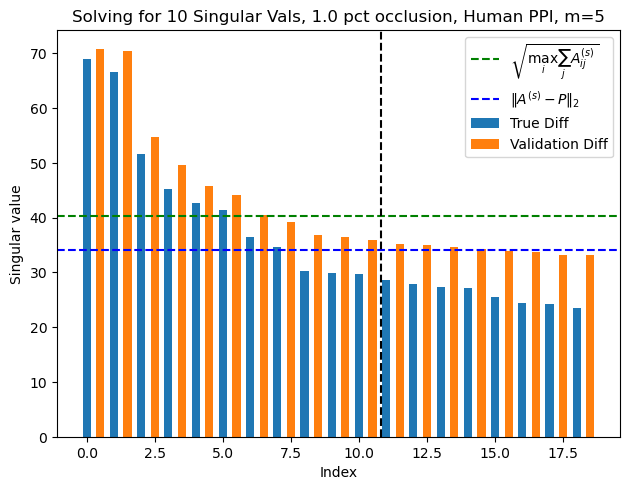

In [16]:
gl.plot_scipy_optimize_result_and_save(result, sample_mats, validation_mat, ground_truth_mat, num_eigs_to_include, 20)

## try different optimizer

### SLSQP with eta upper bound of 10.0

In [10]:
scipy.optimize.show_options(method='SLSQP')




minimize


bfgs
====

Minimization of scalar function of one or more variables using the
BFGS algorithm.

Options
-------
disp : bool
    Set to True to print convergence messages.
maxiter : int
    Maximum number of iterations to perform.
gtol : float
    Terminate successfully if gradient norm is less than `gtol`.
norm : float
    Order of norm (Inf is max, -Inf is min).
eps : float or ndarray
    If `jac is None` the absolute step size used for numerical
    approximation of the jacobian via forward differences.
return_all : bool, optional
    Set to True to return a list of the best solution at each of the
    iterations.
finite_diff_rel_step : None or array_like, optional
    If `jac in ['2-point', '3-point', 'cs']` the relative step size to
    use for numerical approximation of the jacobian. The absolute step
    size is computed as ``h = rel_step * sign(x) * max(1, abs(x))``,
    possibly adjusted to fit into the bounds. For ``method='3-point'``
    the sign of `h` is ignore

In [14]:
m = len(sample_mats)
eta_init = gl.generate_random_eta(m)
delta_scaling = 0.1
delta = gl.delta_estimate(validation_mat, scaling=delta_scaling)
num_eigs_to_include = 10

objective = lambda eta_arr: gl.objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True, 
                                                         num_eigs_included=num_eigs_to_include)
slsqp_options = {
    'disp': True, 
    
}
eta_ub = 10.0
bounds_list = [(0.0, eta_ub) for _ in range(len(sample_mats))]

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='SLSQP',
    jac=None,
    bounds=bounds_list,
    options=slsqp_options
)

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 460.2573270228558
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1


In [15]:
result

 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 460.2573270228558
       x: [ 3.896e-01  4.056e-01  2.048e-01]
     nit: 1
     jac: [ 1.635e+08  1.447e+08  3.121e+07]
    nfev: 4
    njev: 1

Weird! No idea why the constraints are not valid. 

### SLSQP with upper bound of 1.0 on eta

In [16]:
m = len(sample_mats)
eta_init = gl.generate_random_eta(m)
delta_scaling = 0.1
delta = gl.delta_estimate(validation_mat, scaling=delta_scaling)
num_eigs_to_include = 10

objective = lambda eta_arr: gl.objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True, 
                                                         num_eigs_included=num_eigs_to_include)
slsqp_options = {
    'disp': True, 
    
}
# changethis
eta_ub = 1.0
bounds_list = [(0.0, eta_ub) for _ in range(len(sample_mats))]

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='SLSQP',
    jac=None,
    bounds=bounds_list,
    options=slsqp_options
)

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 360.12197805129955
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1


### No constraints

In [17]:
m = len(sample_mats)
eta_init = gl.generate_random_eta(m)
delta_scaling = 0.1
delta = gl.delta_estimate(validation_mat, scaling=delta_scaling)
num_eigs_to_include = 10

objective = lambda eta_arr: gl.objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True, 
                                                         num_eigs_included=num_eigs_to_include)
slsqp_options = {
    'disp': True, 
    
}
# changethis
eta_ub = 1.0
bounds_list = [(0.0, eta_ub) for _ in range(len(sample_mats))]

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='SLSQP',
    jac=None,
    bounds=None,
    options=slsqp_options
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.7526916510906964e+16
            Iterations: 19
            Function evaluations: 175
            Gradient evaluations: 19


Whoa! That's terrible. We really need those constraints I think.

### Nelder Mead

In [19]:
m = len(sample_mats)
eta_init = gl.generate_random_eta(m)
delta_scaling = 0.1
delta = gl.delta_estimate(validation_mat, scaling=delta_scaling)
num_eigs_to_include = 10

objective = lambda eta_arr: gl.objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True, 
                                                         num_eigs_included=num_eigs_to_include)
options_dict = {
    'disp': True, 
    
}
# changethis
eta_ub = 1.0
bounds_list = [(0.0, eta_ub) for _ in range(len(sample_mats))]

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='Nelder-Mead',
    jac=None,
    bounds=bounds_list,
    options=options_dict
)

/tmp/ipykernel_795365/3636090257.py:17: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = scipy.optimize.minimize(


In [22]:
result

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 348.1754567593224
             x: [ 7.938e-02  2.756e-01  6.697e-01]
           nit: 222
          nfev: 600
 final_simplex: (array([[ 7.938e-02,  2.756e-01,  6.697e-01],
                       [ 7.938e-02,  2.756e-01,  6.697e-01],
                       [ 7.938e-02,  2.756e-01,  6.697e-01],
                       [ 7.938e-02,  2.756e-01,  6.697e-01]]), array([ 3.482e+02,  3.546e+02,  3.548e+02,  3.560e+02]))

In [23]:
sns.set_style('darkgrid')

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[1.29728422]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
1.2972842173739163.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[1.29728422]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


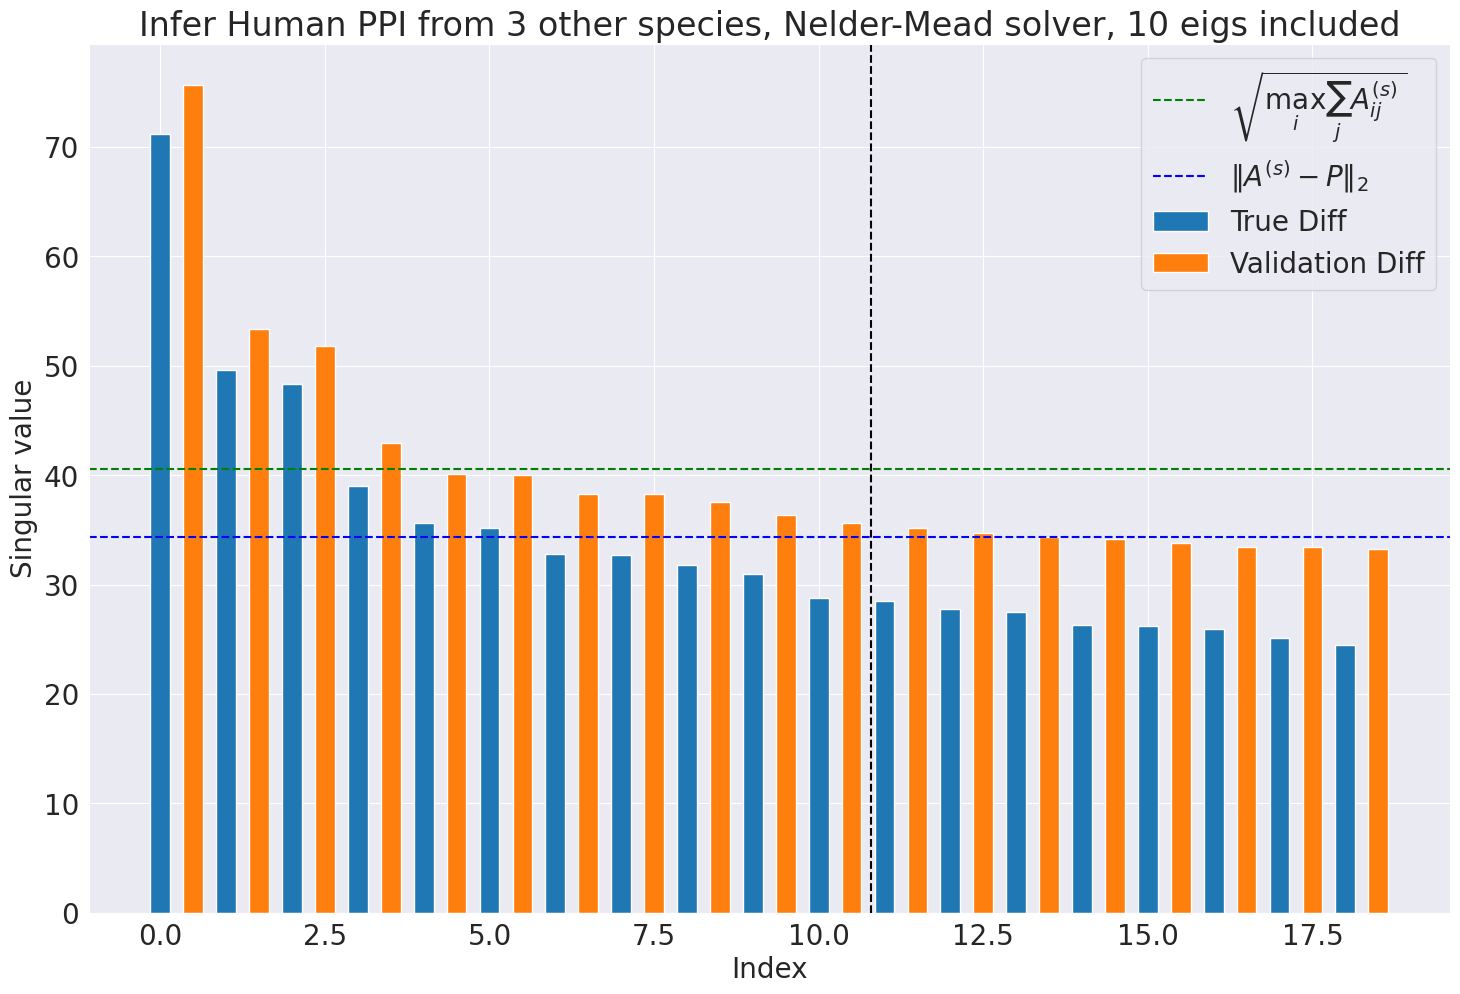

In [31]:
gl.plot_scipy_optimize_result_and_save(result, sample_mats, validation_mat, ground_truth_mat, 
                                       num_eigs_solver=10, num_eigs_to_show=20, 
                                       title_str='Infer Human PPI from 3 other species, Nelder-Mead solver, 10 eigs included')

## run for bos taurus 

Note that we include bos mutus (72004) and bos taurus (9913), and bison (43346). So we should do a better job for bos taurus. 

In [33]:
def gen_multispecies_data(adj_mats_dict, target_species_id): 
    ground_truth_mat = adj_mats_dict[target_species_id]
    sample_mats = [adj_mats_dict[idx] for idx in adj_mats_dict.keys() if idx != target_species_id]
    validation_mat = gl.gen_sparse_sample_boolean_mat(ground_truth_mat)
    return ground_truth_mat, validation_mat, sample_mats

In [34]:
ground_truth_mat, validation_mat, sample_mats = gen_multispecies_data(adj_mats_dict, 9913)

In [35]:
m = len(sample_mats)
eta_init = gl.generate_random_eta(m)
delta_scaling = 0.1
delta = gl.delta_estimate(validation_mat, scaling=delta_scaling)
num_eigs_to_include = 25

objective = lambda eta_arr: gl.objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True, 
                                                         num_eigs_included=num_eigs_to_include)
bfgs_options = {
    'iprint': 5, 
    'maxiter': 500, 
    'ftol': 1e-12, 
    'gtol': 1e-12, 
}

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='L-BFGS-B',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    options=bfgs_options
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73284D+02    |proj g|=  7.31895D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4     35      6     0     0   7.319D-01   8.723D+02
  F =   872.28945441364249     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [36]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 872.2894544136425
        x: [ 2.974e-01  4.345e-01  2.681e-01]
      nit: 4
      jac: [ 1.214e+08  2.982e+08 -1.605e+08]
     nfev: 140
     njev: 35
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[6.55170617]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
6.551706170031679.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[6.55170617]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


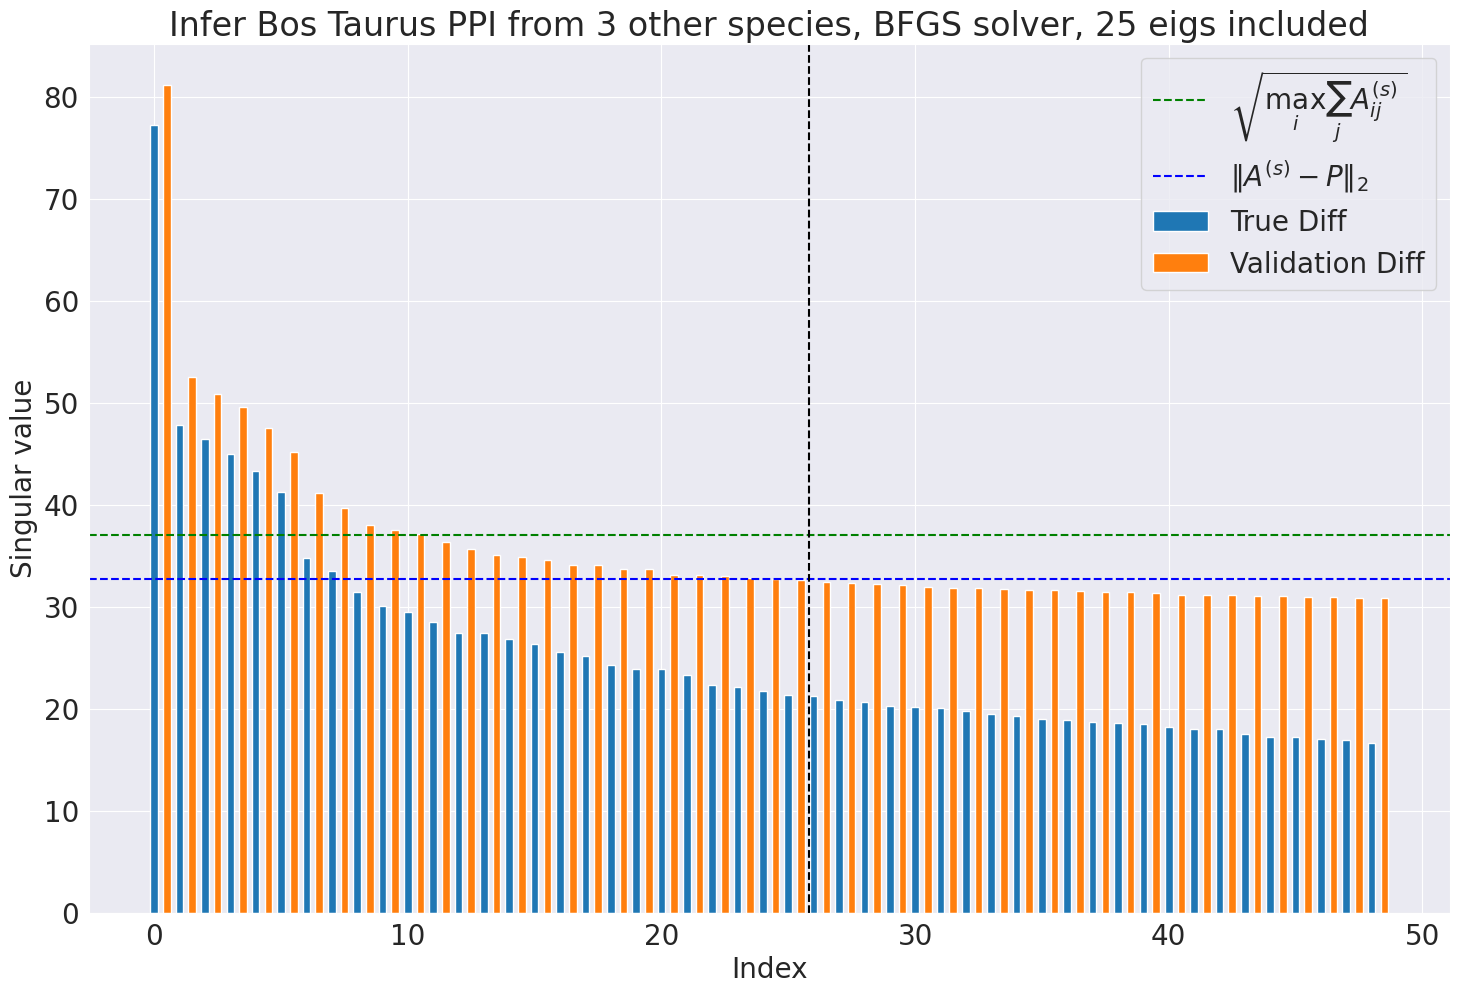

In [38]:
gl.plot_scipy_optimize_result_and_save(result, sample_mats, validation_mat, ground_truth_mat, 
                                       num_eigs_solver=num_eigs_to_include, num_eigs_to_show=50, 
                                       title_str='Infer Bos Taurus PPI from 3 other species, BFGS solver, 25 eigs included')

In [39]:
result['x']

array([0.29738747, 0.43450799, 0.26810508])

In [40]:
[idx for idx in adj_mats_dict.keys() if idx != 9913]

[9606, 72004, 43346]

## other ways of improving the algorithms

* More eigenvalues to include in the optimizer

* Get more data, and especially more accurate data!